# **AxisVM** vs. **SigmaEpsilon** - Membranes

In [1]:
L = 10.0  # length of the beam
h = 2.0  # height of the cross-section
b = 0.2  # width of the cross section
pz = -10.0  # intensity of vertical distributed load
px = 0.0  # intensity of horizontal distributed load


In [2]:
from dewloosh.core import DeepDict
from time import time

summary = DeepDict()


# **AxisVM**

In [3]:
from axisvm.com.client import start_AxisVM
axvm = start_AxisVM(visible=True, daemon=True)


In [4]:
from axisvm.com.tlb import RSurfaceAttr, lnlTensionAndCompression, \
    RResistancesXYZ, schLinear, stMembraneStress, RElasticFoundationXYZ, \
    RNonLinearityXYZ
import axisvm.com.tlb as axtlb
from axisvm.com.tlb import dofYfix
import numpy as np

modelId = axvm.Models.New()
axm = axvm.Models[modelId]
wdir = ""

axm.Settings.NationalDesignCode = axtlb.ndcEuroCode
matId = axm.Materials.AddFromCatalog(axtlb.ndcEuroCode, "C16/20")

coords = np.zeros((6, 3))  # we have six points in a 3d space
coords[0, :] = 0., 0., -h/2
coords[1, :] = 0., 0., 0.
coords[2, :] = 0., 0., h/2
coords[3, :] = L, 0., -h/2
coords[4, :] = L, 0., 0.
coords[5, :] = L, 0., h/2

# we are working in the x-z plane, so all nodes are supported
# against displacement in y-direction
fnc = axm.Nodes.AddWithDOF
nodeIDs = list(map(lambda c: fnc(*c, dofYfix), coords))

nodes_of_lines = [[0, 1], [1, 2], [3, 4], [4, 5], [0, 3], [1, 4], [2, 5]]
LineGeomType = axtlb.lgtStraightLine
lineIDs = []
for line in nodes_of_lines:
    lineIDs.append(axm.Lines.Add(nodeIDs[line[0]], nodeIDs[line[1]],
                   LineGeomType, axtlb.RLineGeomData())[1])

sattr = RSurfaceAttr(
    Thickness=b,
    SurfaceType=stMembraneStress,
    RefZId=0,
    RefXId=0,
    MaterialId=matId,
    ElasticFoundation=RElasticFoundationXYZ(0, 0, 0),
    NonLinearity=RNonLinearityXYZ(lnlTensionAndCompression,
                                  lnlTensionAndCompression,
                                  lnlTensionAndCompression),
    Resistance=RResistancesXYZ(0, 0, 0),
    Charactersitics=schLinear)

lines_of_domains = [[0, 4, 2, 5], [1, 5, 3, 6]]
domainIDs = []
for d in lines_of_domains:
    domainIDs.append(axm.Domains.Add(LineIds=[lineIDs[i] for i in d],
                                     SurfaceAttr=sattr)[1])

lines3d = axvm.ObjectCreator.NewLines3d()
line3d = axtlb.RLine3d(
    LineType=axtlb.ltStraightLine3d,
    P1=axtlb.RPoint3d(0, 0, 0),
    P2=axtlb.RPoint3d(L, 0, 0)
)
lines3d.Add(line3d)
LoadDomainPolyLine = axtlb.RLoadDomainPolyLine(
    LoadCaseId=1,
    px1=px,
    px2=px,
    py1=0,
    py2=0,
    pz1=pz,
    pz2=pz,
    DistributionType=axtlb.dtGlobal,
    Nx=0,
    Ny=0,
    Nz=1
)
_ = axm.Loads.AddDomainPolyLine(lines3d, LoadDomainPolyLine)

springleft = axtlb.RStiffnesses(
    x=1e12,
    y=1e12,
    z=1e12,
    xx=0,
    yy=0,
    zz=0
)
springright = axtlb.RStiffnesses(
    x=1e12,
    y=1e12,
    z=1e12,
    xx=0,
    yy=0,
    zz=0
)
RNonLinearity = axtlb.RNonLinearity(
    x=axtlb.lnlTensionAndCompression,
    y=axtlb.lnlTensionAndCompression,
    z=axtlb.lnlTensionAndCompression,
    xx=axtlb.lnlTensionAndCompression,
    yy=axtlb.lnlTensionAndCompression,
    zz=axtlb.lnlTensionAndCompression
)
RResistances = axtlb.RResistances(
    x=0,
    y=0,
    z=0,
    xx=0,
    yy=0,
    zz=0
)
_ = axm.NodalSupports.AddNodalGlobal(springleft, RNonLinearity,
                                     RResistances, nodeIDs[1])
_ = axm.NodalSupports.AddNodalGlobal(springright, RNonLinearity,
                                     RResistances, nodeIDs[4])

MeshParams = axtlb.RDomainMeshParameters(
    MeshSize=h/5,
    MeshType=axtlb.mtAdaptive,
    MeshGeometryType=axtlb.mgtMixedQuadTriangle
)
axm.Domains[:].GenerateMesh(MeshParams)

# turn off the grid
GridOptions = axtlb.RGridOptions(DisplayGrid=False)
axm.Settings.SetGridOptions(GridOptions)

fpath = wdir + 'ss_beam_M.axs'
axm.SaveToFile(fpath, False)
axm.Calculation.LinearAnalysis(axtlb.cuiNoUserInteractionWithAutoCorrectNoShow)


1

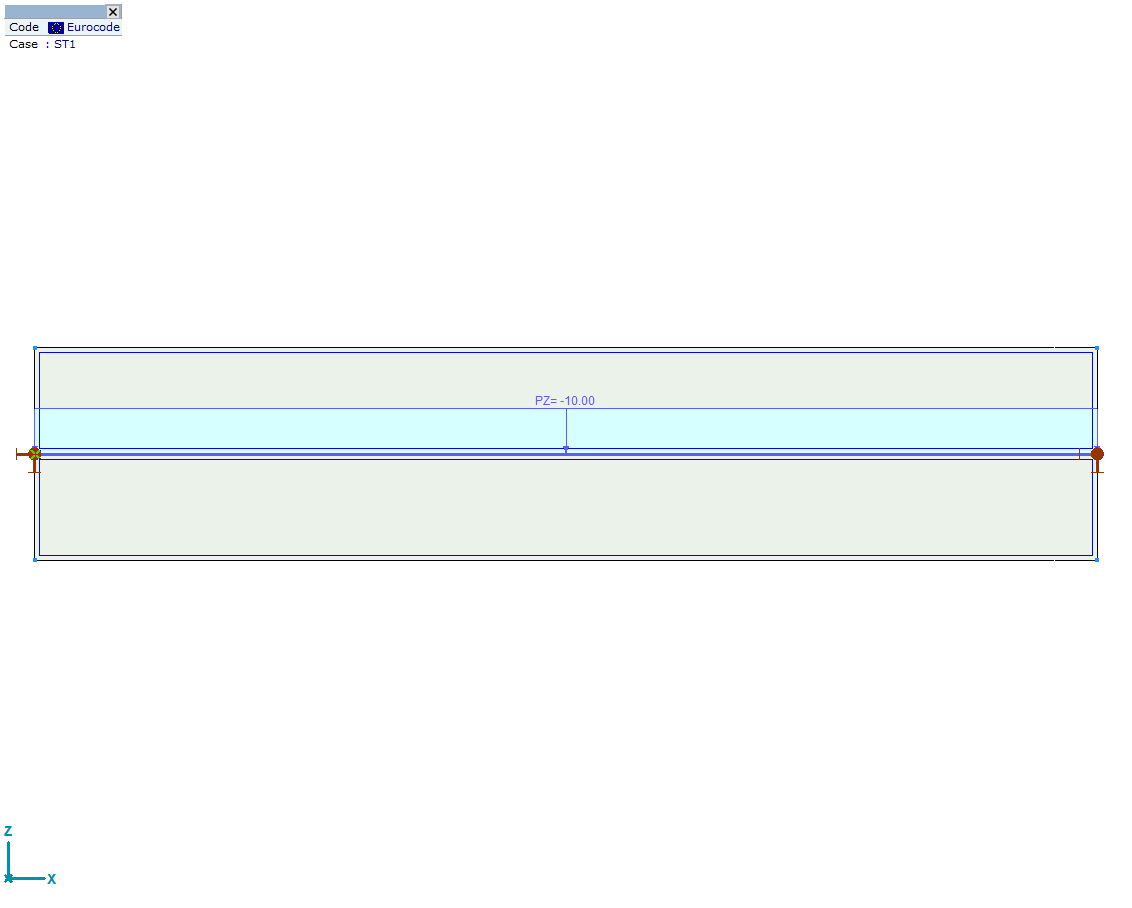

In [5]:
axm.View = axtlb.vFront
axvm.MainFormTab = axtlb.mftGeometry
axm.FitInView()
axm.Windows[1].screenshot()


In [6]:
# we want the front of the domains to fill up the screen entirely
axm.View = axtlb.vFront
axm.FitInView()

WriteValuesTo = axtlb.RWriteValuesTo(
    Nodes=True,
    Lines=True,
    Surfaces=False,
    MinMaxOnly=True
)

BasicDispParams = axtlb.RBasicDisplayParameters_V153(
    ResultComponent=axtlb.rc_d_eZ,
    Scale=1.0,
    DisplayMode=axtlb.dmIsosurfaces2D,
    DisplayShape=axtlb.dsUndeformed,
    WriteValuesTo=WriteValuesTo
)

ExtDispParams = axtlb.RExtendedDisplayParameters_V153(
    BasicDispParams=BasicDispParams,
    DisplayAnalysisType=axtlb.datLinear,
    ResultType=axtlb.rtLoadCase
)

axm.Windows.SetStaticDisplayParameters_V153(1, ExtDispParams, 1, [])

axm.Windows.ReDraw()
imgpath = wdir + 'ss_beam_M_ez.bmp'
axm.Windows[1].SaveWindowToBitmap(axtlb.wcmColour, imgpath)
axvm.BringToFront()


1

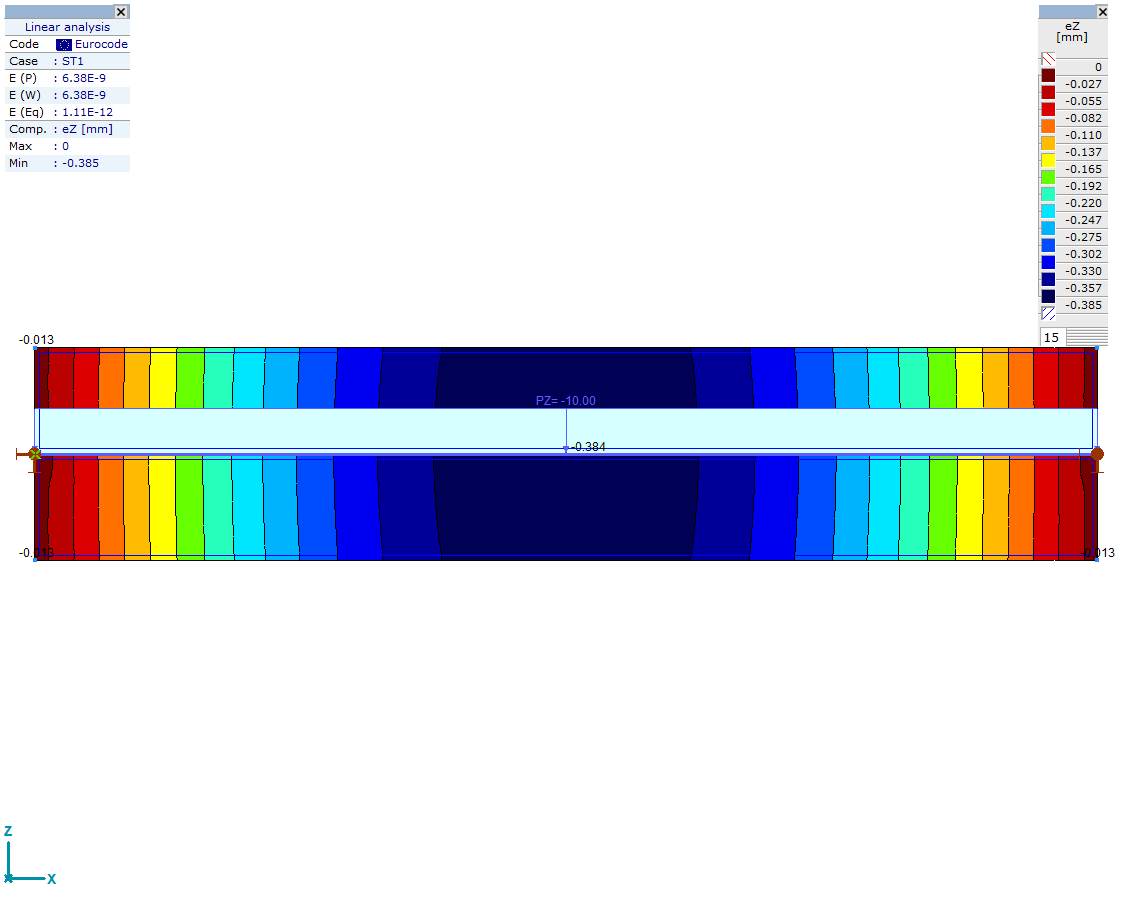

In [7]:
axm.Windows[1].screenshot()


In [8]:
axm.Domains[1].topology()

TopologyArray
([[1, 7, 57, 33, 177, 231, 345, 206], [7, ... [78, 79, 81, 82, 299, 323, 301, 324]])

In [9]:
axm.Domains[1].triangles()

array([[  1, 177, 206],
       [177,   7, 231],
       [231,  57, 345],
       ...,
       [348,  81, 323],
       [300, 323,  79],
       [300, 348, 323]], dtype=int64)

In [10]:
axm.Surfaces.topology()

TopologyArray
([[1, 7, 57, 33, 177, 231, 345, 206], ... [152, 153, 154, 155, 450, 497, 498, 473]])

In [11]:
axm.Surfaces.triangles()

array([[  1, 177, 206],
       [177,   7, 231],
       [231,  57, 345],
       ...,
       [496, 131, 494],
       [472, 494, 176],
       [472, 496, 494]], dtype=int64)

In [12]:
axm.Domains.triangles()

array([[  1, 177, 206],
       [177,   7, 231],
       [231,  57, 345],
       ...,
       [496, 131, 494],
       [472, 494, 176],
       [472, 496, 494]], dtype=int64)

In [13]:
coords = axm.coords()
triangles = axm.Surfaces.triangles() - 1


In [14]:
disps = axm.Results.Displacements
disps.DisplacementSystem = axtlb.dsGlobal
disps.LoadCaseId = 1
disps.LoadLevelOrModeShapeOrTimeStep = 1
def fnc(i): return disps.NodalDisplacementByLoadCaseId(i+1)[0].ez

data = np.array(list(map(fnc, range(len(coords))))) * 1000


In [15]:
%matplotlib inline


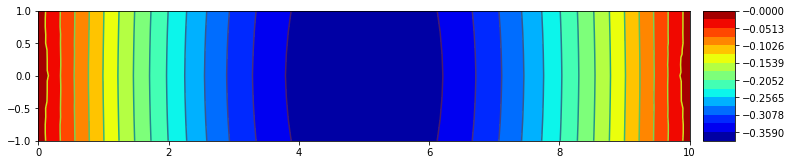

In [16]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from dewloosh.mesh.tri import triplot, triangulate

px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(800*px, 200*px))

triobj = tri.Triangulation(coords[:, 0], coords[:, 2], triangles=triangles)

triplot(triobj, data=data, fig=fig, ax=ax, nlevels=15, cmap='jet', axis='on', offset=0.,
        cbpad='2%', cbsize='5%', cbpos='right')

fig.tight_layout()
plt.show()

In [17]:
axm.Lines.model


IAxisVMModel,Information
N Nodes,176
N Lines,322
N Members,7
N Surfaces,147
N Domains,2


In [18]:
axm.Lines.plot()


In [19]:
axm.Surfaces.plot(scalars=data, plot_edges=True)


In [20]:
axm.Surfaces.plot(plot_edges=True)


In [21]:
axm.Domains[1].plot()


In [ ]:
import axisvm.com.tlb as axtlb
import numpy as np
from neumann import minmax

disps = axm.Results.Displacements
disps.DisplacementSystem = axtlb.dsGlobal
disps.LoadCaseId = 1
disps.LoadLevelOrModeShapeOrTimeStep = 1

recs = disps.AllNodalDisplacementsByLoadCaseId()[0]
dofsol = np.array(list(map(lambda r : [r.ex, r.ey, r.ez, r.Fx, r.Fy, r.Fz], recs)))